In [3]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.append('/home/flink/workspace/yimin/Flink-SQL-Metrics-Tracer/src/cleaners')
from seq_cleaner import *

In [4]:
f_paths = ['/home/flink/workspace/yimin/datasets/nexmark_full_job_Nov14/test/test2.csv',
           '/home/flink/workspace/yimin/datasets/nexmark_full_job_Nov14/test/test3.csv',
           '/home/flink/workspace/yimin/datasets/nexmark_full_job_Nov14/test/test4.csv',
           '/home/flink/workspace/yimin/datasets/nexmark_full_job_Nov14/test/test5.csv',
          ]
df_raws = []
for f_path in f_paths:
    df_raws.append(pd.read_csv(f_path))
df_raw = pd.concat(df_raws, axis=0, ignore_index=True)

In [5]:
df_raw.shape

(6060, 2)

In [6]:
# define wanted dict
wanted_dict = {}
wanted_dict['run_confs'] = ['qid', 'parallel', 'tps',]
wanted_dict['vertex_level_metrics'] = ['parallelism',]
wanted_dict['vertex_id'] = 'idx'
wanted_dict['sub_level_metrics'] = ['busyTimeMsPerSecond',
                                    'numBytesOutPerSecond', 'numRecordsOutPerSecond',
                                    'numBytesInPerSecond', 'numRecordsInPerSecond',
                                    'isBackPressured']

In [5]:
in_stream_infos = {"in": {"0": {"0": 0}, "1": {"0": 0}, "2": {"0": 0}, "3": {"0": 0, "1": 1}, "4": {"0": 0, "1": 1, "2": 1, "3": 1}, "5": {"0": 0, "1": 1, "2": 1, "3": 2}, "7": {"0": 0, "1": 1, "2": 2}, "8": {"0": 0, "1": 1, "2": 1, "3": 2}, "9": {"0": 0, "1": 1, "2": 1}, "10": {"0": 0, "1": 1}, "11": {"0": 0, "1": 1}, "12": {"0": 0, "1": 1}, "13": {"0": 0}, "14": {"0": 0}, "15": {"0": 0, "1": 1}, "16": {"0": 0, "1": 1}, "17": {"0": 0, "1": 1}, "18": {"0": 0, "1": 1}, "19": {"0": 0, "1": 1}, "20": {"0": 0, "1": 1}, "21": {"0": 0}, "22": {"0": 0}}, "out": {"0": {"0": 0}, "1": {"0": 0}, "2": {"0": 0}, "3": {"0": 1, "1": 0}, "4": {"0": 1, "1": 1, "2": 1, "3": 0}, "5": {"0": 1, "1": 2, "2": 1, "3": 0}, "7": {"0": 2, "1": 1, "2": 0}, "8": {"0": 2, "1": 1, "2": 1, "3": 0}, "9": {"0": 1, "1": 1, "2": 0}, "10": {"0": 1, "1": 0}, "11": {"0": 1, "1": 0}, "12": {"0": 1, "1": 0}, "13": {"0": 0}, "14": {"0": 0}, "15": {"0": 1, "1": 0}, "16": {"0": 1, "1": 0}, "17": {"0": 1, "1": 0}, "18": {"0": 1, "1": 0}, "19": {"0": 1, "1": 0}, "20": {"0": 1, "1": 0}, "21": {"0": 0}, "22": {"0": 0}}}

In [6]:
in_stream_infos["in"]['4']['0']
in_stream_infos["out"]['4']['0']

1

In [7]:
# do data cleaning
scleaner = sequential_cleaner(wanted_dict)
df_raw[:].apply(scleaner.clean_row, axis=1)
len(scleaner.dataset), scleaner.dataset[:1]

(108240,
 [[4, 2, 10000, 0, 2, 0, 'NaN', '34406.4', '838.7', '0.0', '0.0', 'false']])

In [8]:
df = pd.DataFrame(scleaner.dataset, columns=scleaner.get_head())

In [9]:
df = df.replace('NaN', np.nan)

In [10]:
row_n = df.shape[0]
col_n = df.shape[1]
row_n, col_n

(108240, 12)

In [11]:
df.keys()

Index(['qid', 'parallel', 'tps', 'vertex_idx', 'parallelism', 'sub_idx',
       'busyTimeMsPerSecond', 'numBytesOutPerSecond', 'numRecordsOutPerSecond',
       'numBytesInPerSecond', 'numRecordsInPerSecond', 'isBackPressured'],
      dtype='object')

In [12]:
# df_check = df[df['qid'] == 5]
# df_check = df_check[df_check['vertex_idx'] == 1]
# list(df_check['Shuffle.Netty.Input.Buffers.inputQueueSize'][-100:])

In [12]:
busyTime = df['busyTimeMsPerSecond']

In [13]:
sum(busyTime.isnull()) / row_n # 70% of the data has the busy time metrics

0.4007760532150776

In [14]:
# naive demo: {qid, vid, parallelism, numBytesInPerSecond} => busyTimeMsPerSecond
# df_naive = df.filter(items=['query_idx', 'vertex_idx', 'parallelism', 'numBytesInPerSecond', 'numRecordsInPerSecond', 'busyTimeMsPerSecond'])
df_naive = df

In [15]:
# make complete dataset with input stream infos
def complete_stream_num_infos(qid, vid, io='in'):
#     print(qid, vid)
    qid = int(qid)
    vid = int(vid)
    if io == 'in':
        return in_stream_infos['in'][str(qid)][str(vid)]
    elif io == 'out':
        return in_stream_infos['out'][str(qid)][str(vid)]

def complete_row_in(row):
    return complete_stream_num_infos(row['query_idx'], row['vertex_idx'])

def complete_row_out(row):
    return complete_stream_num_infos(row['query_idx'], row['vertex_idx'], 'out')

# follow-test
complete_stream_num_infos(7, 2, 'in')

2

In [16]:
# df_naive = df_naive[df_naive['busyTimeMsPerSecond'].notnull()]
df_naive.rename(columns = {'qid':'query_idx',}, inplace = True)
print(df_naive.keys())
df_naive = df_naive.astype({"query_idx": int, 'vertex_idx': int, 'sub_idx':int,
                            'parallel': int, 'tps':float,
                            'parallelism':int,
                           'busyTimeMsPerSecond': float, 
#                            'Shuffle.Netty.Input.Buffers.inputQueueLength': float,
#                            'Shuffle.Netty.Input.Buffers.inputQueueSize': float,
#                            'Shuffle.Netty.Input.Buffers.inPoolUsage': float,
#                             'Shuffle.Netty.Output.Buffers.outputQueueSize': float,
                           'numBytesInPerSecond': float, 'numRecordsInPerSecond': float,
                           'numBytesOutPerSecond': float, 'numRecordsOutPerSecond': float,
                           })

df_naive['in_stream_num'] = df_naive.apply(complete_row_in, axis=1)
df_naive['out_stream_num'] = df_naive.apply(complete_row_out, axis=1)

# df_naive = df_naive[df_naive['busyTimeMsPerSecond'] < 1000]
# df_naive = df_naive[df_naive['busyTimeMsPerSecond'] > 10]

Index(['query_idx', 'parallel', 'tps', 'vertex_idx', 'parallelism', 'sub_idx',
       'busyTimeMsPerSecond', 'numBytesOutPerSecond', 'numRecordsOutPerSecond',
       'numBytesInPerSecond', 'numRecordsInPerSecond', 'isBackPressured'],
      dtype='object')


In [17]:
df_naive

,query_idx,parallel,tps,vertex_idx,parallelism,sub_idx,busyTimeMsPerSecond,numBytesOutPerSecond,numRecordsOutPerSecond,numBytesInPerSecond,numRecordsInPerSecond,isBackPressured,in_stream_num,out_stream_num
0,4,2,10000.0,0,2,0,NaN,34406.400000,838.700000,0.000000e+00,0.000000,false,0,1
1,4,2,10000.0,0,2,1,NaN,33860.266667,838.700000,0.000000e+00,0.000000,false,0,1
2,4,2,10000.0,1,2,0,141.0,24029.866667,597.916667,3.523568e+04,846.800000,false,1,1
3,4,2,10000.0,1,2,1,133.0,19660.800000,489.750000,3.443827e+04,828.216667,false,1,1
4,4,2,10000.0,2,2,0,48.0,5461.333333,175.383333,2.258533e+04,549.983333,false,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108235,20,16,2400000.0,1,16,11,744.0,0.000000,0.000000,3.477390e+06,15533.216667,false,1,0
108236,20,16,2400000.0,1,16,12,844.0,0.000000,0.000000,3.424530e+06,15289.300000,false,1,0
108237,20,16,2400000.0,1,16,13,807.0,0.000000,0.000000,3.447554e+06,15400.683333,false,1,0
108238,20,16,2400000.0,1,16,14,868.0,0.000000,0.000000,3.440923e+06,15364.700000,false,1,0


In [18]:
def draw_scatter(df, qid, vid, parallelism, x='numBytesInPerSecond', y='busyTimeMsPerSecond', scale=1, label=None, alpha=0.05):
    tmp_df = df[df['query_idx']==qid]
    tmp_df = tmp_df[tmp_df['vertex_idx']==vid]
    tmp_df = tmp_df[tmp_df['parallelism']==parallelism]
    
    plt.scatter(tmp_df[x],
                tmp_df[y]*scale,
                label=label if label else ''.join(['q', str(qid),
                                                   'v', str(vid),
                                                   'p', str(parallelism),
                                                  ]),
                alpha = alpha
               )
    
    plt.title(' '.join([x, 'vs', y]))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

def draw_regression(df, qid, vid, parallelism, x='numBytesInPerSecond', y='busyTimeMsPerSecond', deg=2, scale=1, label=None):
    tmp_df = df[df['query_idx']==qid]
    tmp_df = tmp_df[tmp_df['vertex_idx']==vid]
    tmp_df = tmp_df[tmp_df['parallelism']==parallelism]
    
    p = np.polyfit(tmp_df[x], tmp_df[y]*scale, deg)
    reger = np.poly1d(p)
    xp = np.linspace(min(tmp_df[x]), max(tmp_df[x]), 100)
    
    plt.plot(xp,
             reger(xp),
             '--',
             label=label if label else ''.join(['q', str(qid),
                                                'v', str(vid),
                                                'p', str(parallelism),
                                               ])
            )

    plt.title(' '.join([x, 'vs', y]))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

def compare_scatter(df, sets, labels = [], scales = [], **kwargs):
    ql = len(sets)
    for i in range(ql):
        draw_scatter(df,
                     sets[i][0], sets[i][1], sets[i][2], 
                     label=labels[i] if labels else None,
                     scale=scales[i] if scales else 1,
                     **kwargs)

def compare_regression(df, sets, labels = [], scales=[], **kwargs):
    ql = len(sets)
    for i in range(ql):
        draw_regression(df,
                        sets[i][0], sets[i][1], sets[i][2], 
                        label=labels[i] if labels else None,
                        scale=scales[i] if scales else 1,
                        **kwargs)

def draw_3d(df_naive, qid, vid, parallelism_list = [2, 4, 8, 16]):
    # TODO: naive implement
    # compare set1: q7v2
    df_naive_7 = df_naive[df_naive['query_idx']==qid]
    df_naive_72 = df_naive_7[df_naive_7['vertex_idx']==vid]
    df_naive_72 = df_naive_72.filter(items=['parallelism', 'numBytesInPerSecond', 'numRecordsInPerSecond', 'busyTimeMsPerSecond'])

    fig = plt.figure()
    ax =  Axes3D(fig)
    # ax.scatter()
    for i in range(2, 17):
        if i not in parallelism_list: continue
        df_naive_72_tmp = df_naive_72[df_naive_72['parallelism']==i]
        ax.scatter(df_naive_72_tmp['parallelism'], df_naive_72_tmp['numBytesInPerSecond'], df_naive_72_tmp['busyTimeMsPerSecond'], marker='o')
    ax.set_xlabel('parallelism')
    ax.set_ylabel('numBytesInPerSecond')
    ax.set_zlabel('busyTimeMsPerSecond')


### Assumption: vertice are independent
Ignores the impact of slot sharing things among different vertice

In [19]:
%matplotlib inline

In [20]:
df_naive_nonBP = df_naive[(df_naive['isBackPressured'] == 'false') & (df_naive['vertex_idx'] == 0)]
df_naive_nonBP['perSbTps'] = df_naive_nonBP['tps'] / df_naive_nonBP['parallelism']
df_naive_nonBP

/tmp/ipykernel_59551/2239359573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_naive_nonBP['perSbTps'] = df_naive_nonBP['tps'] / df_naive_nonBP['parallelism']


,query_idx,parallel,tps,vertex_idx,parallelism,sub_idx,busyTimeMsPerSecond,numBytesOutPerSecond,numRecordsOutPerSecond,numBytesInPerSecond,numRecordsInPerSecond,isBackPressured,in_stream_num,out_stream_num,perSbTps
0,4,2,10000.0,0,2,0,NaN,3.440640e+04,838.700000,0.0,0.0,false,0,1,5000.0
1,4,2,10000.0,0,2,1,NaN,3.386027e+04,838.700000,0.0,0.0,false,0,1,5000.0
8,4,2,10000.0,0,2,0,NaN,6.772053e+04,1655.450000,0.0,0.0,false,0,1,5000.0
9,4,2,10000.0,0,2,1,NaN,6.772053e+04,1655.433333,0.0,0.0,false,0,1,5000.0
16,4,2,10000.0,0,2,0,NaN,1.014551e+05,2472.283333,0.0,0.0,false,0,1,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107921,20,16,2400000.0,0,16,1,NaN,9.022123e+05,4062.616667,0.0,0.0,false,0,1,150000.0
107926,20,16,2400000.0,0,16,6,NaN,8.028160e+05,3620.516667,0.0,0.0,false,0,1,150000.0
108022,20,16,2400000.0,0,16,6,NaN,2.701722e+06,12100.333333,0.0,0.0,false,0,1,150000.0
108026,20,16,2400000.0,0,16,10,NaN,2.411179e+06,10816.150000,0.0,0.0,false,0,1,150000.0


In [21]:
df_naive_BP = df_naive[(df_naive['isBackPressured'] == 'true') & (df_naive['vertex_idx'] == 0)]
df_naive_BP['perSbTps'] = df_naive_BP['tps'] / df_naive_BP['parallelism']
df_naive_BP

/tmp/ipykernel_59551/3712642782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_naive_BP['perSbTps'] = df_naive_BP['tps'] / df_naive_BP['parallelism']


,query_idx,parallel,tps,vertex_idx,parallelism,sub_idx,busyTimeMsPerSecond,numBytesOutPerSecond,numRecordsOutPerSecond,numBytesInPerSecond,numRecordsInPerSecond,isBackPressured,in_stream_num,out_stream_num,perSbTps
165,7,2,10000.0,0,2,0,NaN,2.315605e+05,2886.333333,0.0,0.0,true,0,2,5000.0
166,7,2,10000.0,0,2,1,NaN,2.315605e+05,2886.366667,0.0,0.0,true,0,2,5000.0
710,7,2,40000.0,0,2,0,NaN,1.429777e+06,17781.766667,0.0,0.0,true,0,2,20000.0
711,7,2,40000.0,0,2,1,NaN,1.429231e+06,17781.700000,0.0,0.0,true,0,2,20000.0
715,7,2,40000.0,0,2,0,NaN,1.785572e+06,22207.816667,0.0,0.0,true,0,2,20000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108219,20,16,2400000.0,0,16,11,NaN,3.632702e+06,16211.516667,0.0,0.0,true,0,1,150000.0
108220,20,16,2400000.0,0,16,12,NaN,3.600290e+06,16089.666667,0.0,0.0,true,0,1,150000.0
108221,20,16,2400000.0,0,16,13,NaN,3.217086e+06,14365.550000,0.0,0.0,true,0,1,150000.0
108222,20,16,2400000.0,0,16,14,NaN,3.631215e+06,16228.316667,0.0,0.0,true,0,1,150000.0


In [22]:
df_naive_v0 = df_naive[(df_naive['vertex_idx'] == 0)]
df_naive_v0['perSbTps'] = df_naive_v0['tps'] / df_naive_v0['parallelism']

/tmp/ipykernel_59551/554320541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_naive_v0['perSbTps'] = df_naive_v0['tps'] / df_naive_v0['parallelism']


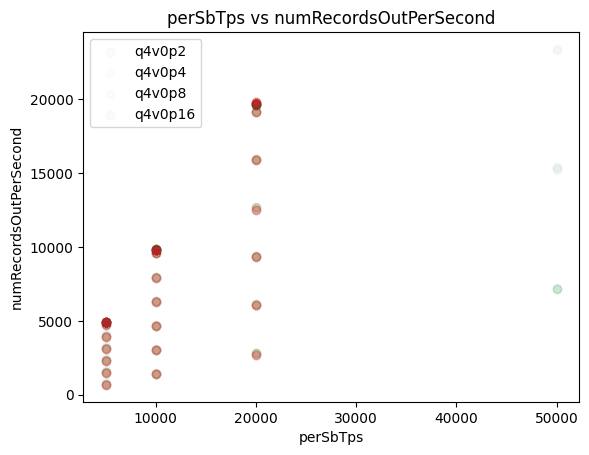

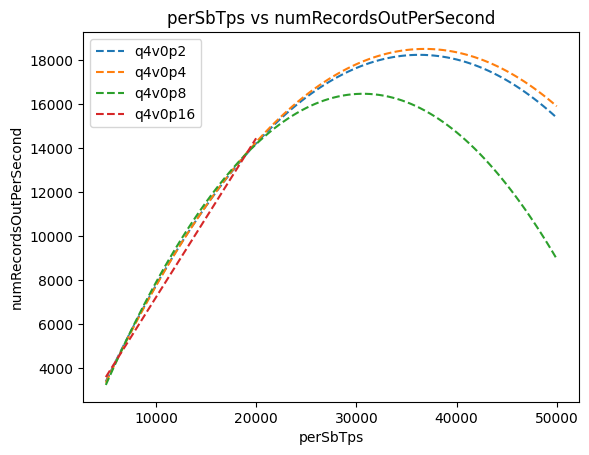

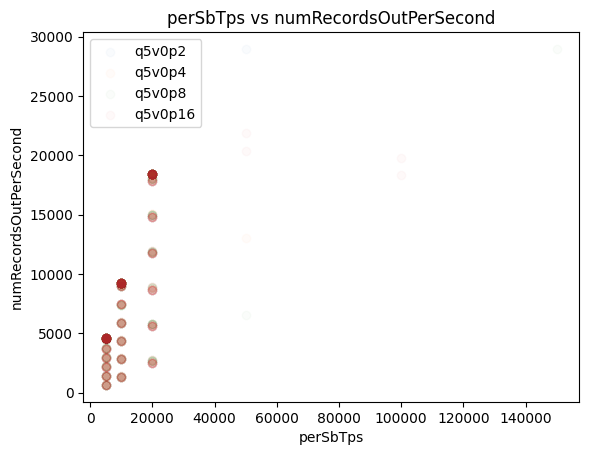

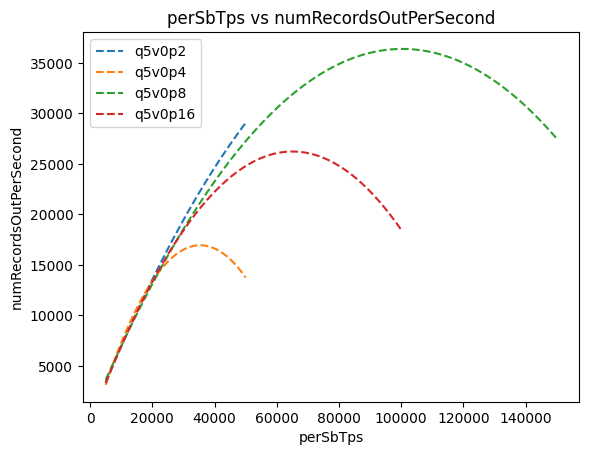

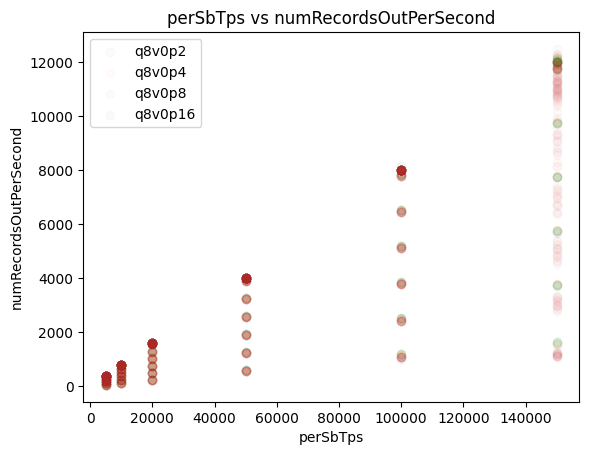

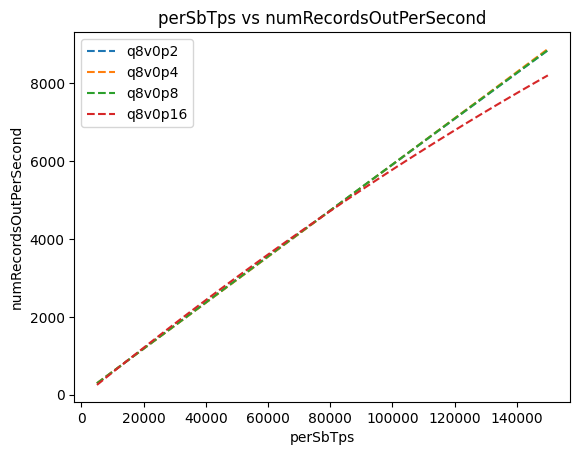

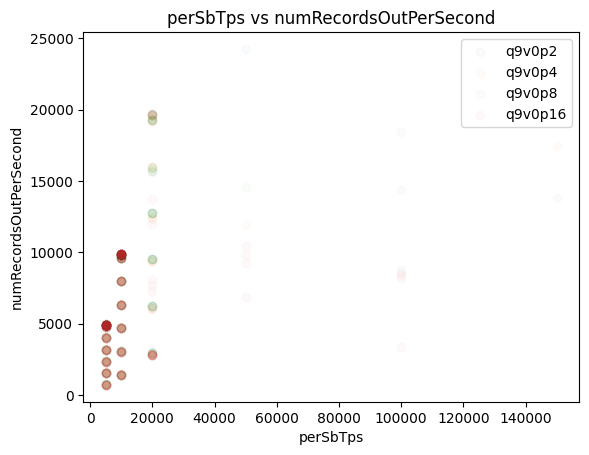

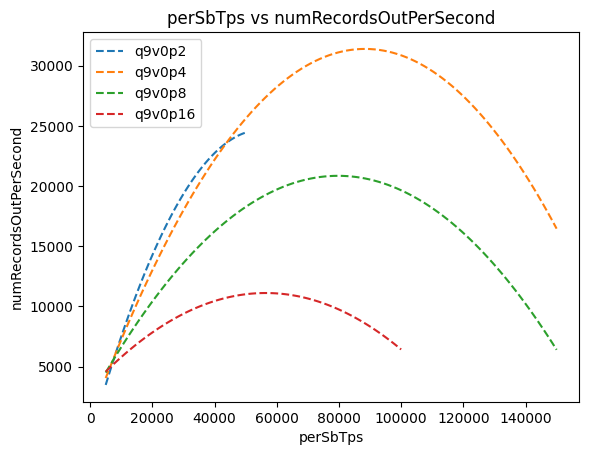

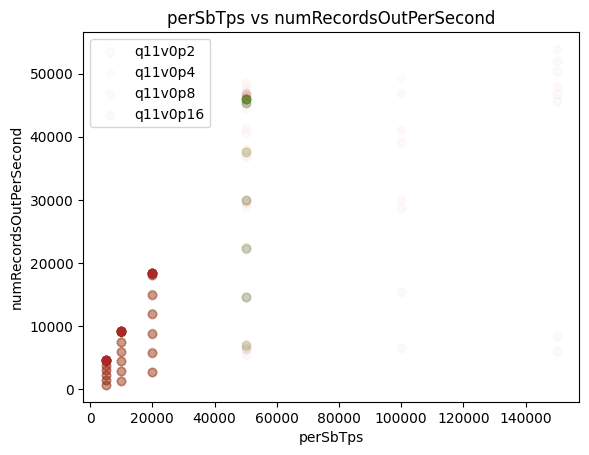

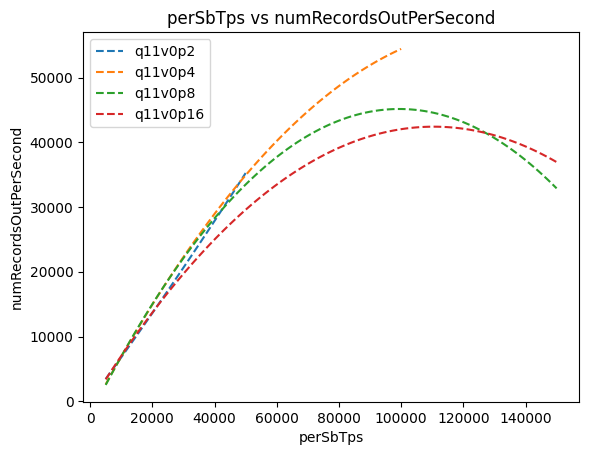

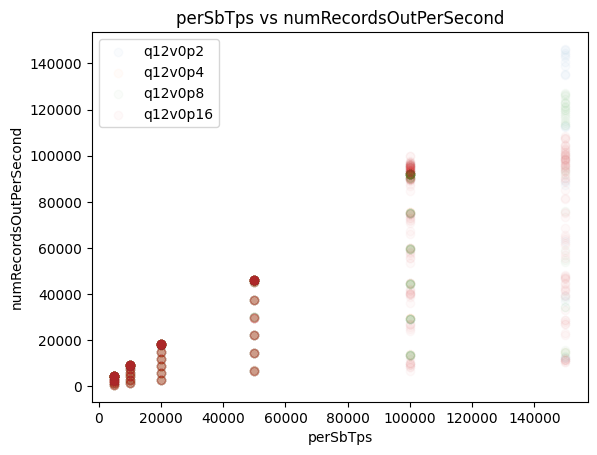

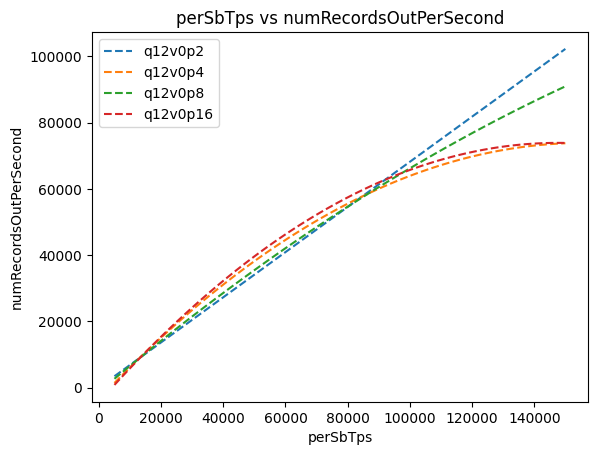

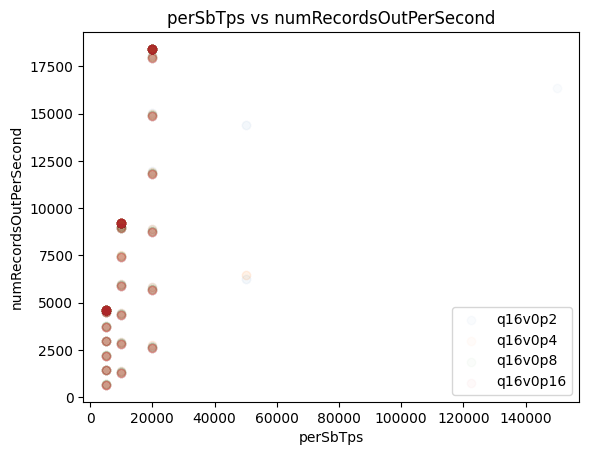

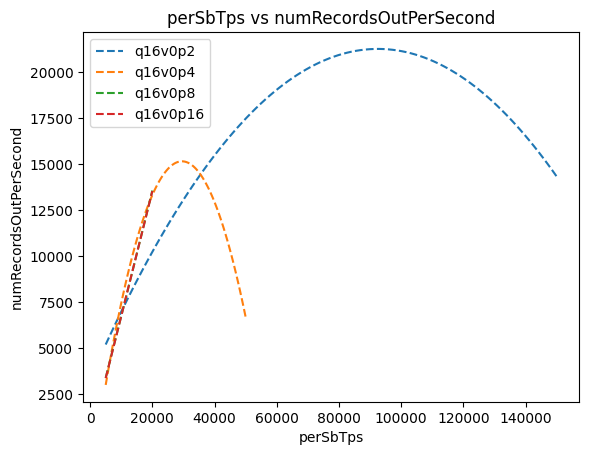

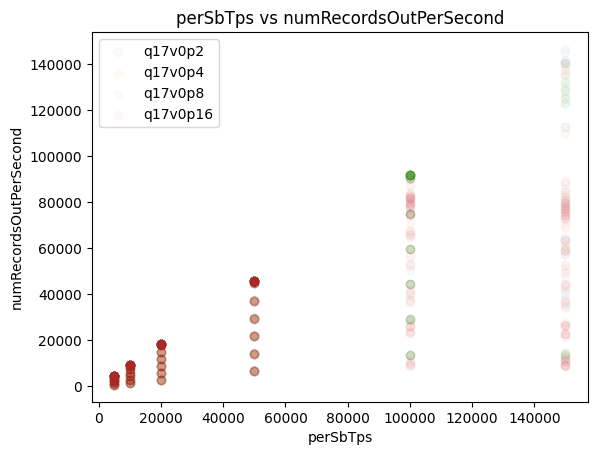

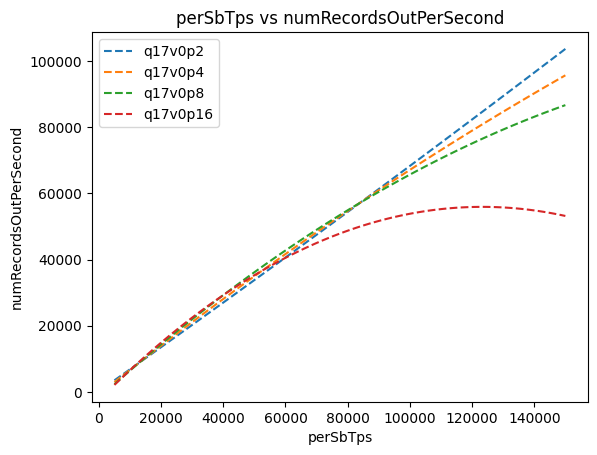

In [29]:
# # sense1: same vertex with diff parallelism (per-subtask)

for tup in [(4,0),(5,0),(8,0),(9,0),(11,0),(12,0),(16,0),(17,0)]:
# for tup in [(4,1),(4,2),(5,1),(5,2),(8,1),(8,2),(9,1),]:
    qid = tup[0]
    vid = tup[1]
    
    # do
    compare_scatter(df_naive_nonBP, [
                               [qid,vid,2],
                               [qid,vid,4],
                               [qid,vid,8],
                               [qid,vid,16]
                          ], 
#                 x='numRecordsInPerSecond', y='numRecordsOutPerSecond',
#                     x='numBytesInPerSecond', y='busyTimeMsPerSecond',
                    x='perSbTps', y='numRecordsOutPerSecond',
#                     x='tps', y='numRecordsOutPerSecond',
                   alpha = 0.025)
    plt.show()

    compare_regression(df_naive_nonBP, [
#                                   [qid,vid,1],
                                  [qid,vid,2],
                                  [qid,vid,4],
                                  [qid,vid,8],
                                  [qid,vid,16]
                                 ], 
#                        x='busyTimeMsPerSecond', y='Shuffle.Netty.Input.Buffers.inPoolUsage')
#                     x='numBytesInPerSecond', y='busyTimeMsPerSecond'
#                     x='numRecordsInPerSecond', y='numRecordsOutPerSecond',
                        x='perSbTps', y='numRecordsOutPerSecond',
#                     x='tps', y='numRecordsOutPerSecond',
                      )
    plt.show()

### try 2 conclude:
Seems like no big diff, but higher parallelism brings less variance/noise, and slightly lower busy time when input rate is the same.

In [72]:
# sense1.2: same vertex with diff parallelism (sum-subtask)

# draw_scatter(df_naive, 7, 2, 2, x='busyTimeMsPerSecond', y='numBytesInPerSecond', scale=2,)
# draw_scatter(df_naive, 7, 2, 4, x='busyTimeMsPerSecond', y='numBytesInPerSecond', scale=4,)
# draw_scatter(df_naive, 7, 2, 8, x='busyTimeMsPerSecond', y='numBytesInPerSecond', scale=8,)
# plt.show()


# draw_regression(df_naive, 7, 2, 2, x='busyTimeMsPerSecond', y='numBytesInPerSecond', scale=2,)
# draw_regression(df_naive, 7, 2, 4, x='busyTimeMsPerSecond', y='numBytesInPerSecond', scale=4,)
# draw_regression(df_naive, 7, 2, 8, x='busyTimeMsPerSecond', y='numBytesInPerSecond', scale=8,)
# plt.show()

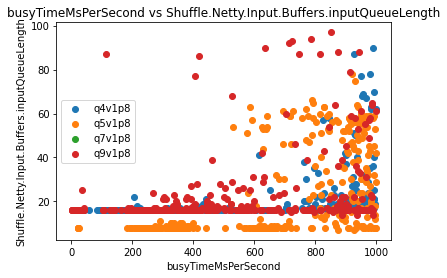

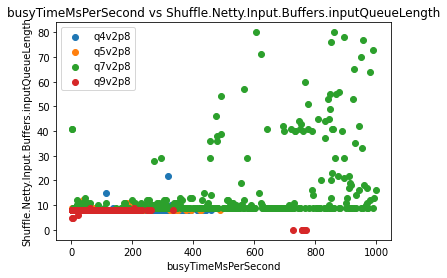

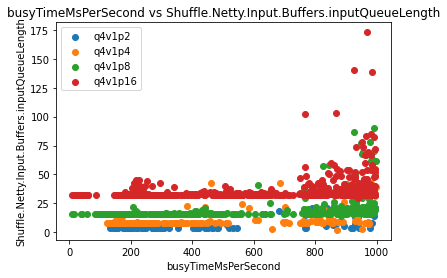

In [93]:
# sense2: diff vertex with same parallelism

compare_scatter(df_naive, [[4,1,8], [5,1,8], [7,1,8], [9,1,8]], x='busyTimeMsPerSecond', y='Shuffle.Netty.Input.Buffers.inputQueueLength')
plt.show()

compare_scatter(df_naive, [[4,2,8], [5,2,8], [7,2,8], [9,2,8]], x='busyTimeMsPerSecond', y='Shuffle.Netty.Input.Buffers.inputQueueLength')
plt.show()

compare_scatter(df_naive, [[4,1,2], [4,1,4], [4,1,8], [4,1,16]], x='busyTimeMsPerSecond', y='Shuffle.Netty.Input.Buffers.inputQueueLength')
plt.show()

### try 2 conclude:
Different vertex greatly differs in busytime when same inputrate, and differs in the curve's shape.

In [26]:
%matplotlib widget

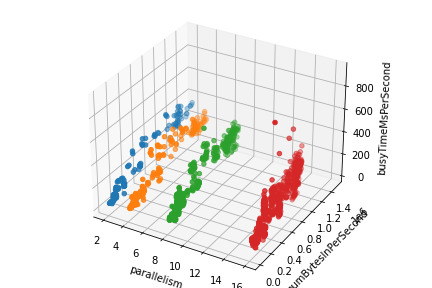

In [27]:
# sense3:  parallelism vs (avg) input_rate vs parallelism (q7, v2)

# compare set 1: q7v2
# draw_3d(df_naive, 7, 2)

# df_naive_clean = df_naive[df_naive['busyTimeMsPerSecond'] >= 0]
draw_3d(df_naive, 4, 2)

plt.show()

In [53]:
# sense4: pairwise corelation explore among more attributes
# this part is somehow trivial since not enough data samples, ignore
# df_rich = df.filter(items=['vertex_idx', 'vertex_name', 'parallelism', 'in_stream_num', 'out_stream_num', 'numBytesInPerSecond', 'numRecordsInPerSecond', 'busyTimeMsPerSecond'])
# df_rich = df_rich[df_rich['busyTimeMsPerSecond'].notnull()]
df_rich = df_naive
df_rich.corr()

,query_idx,vertex_idx,parallelism,sub_idx,busyTimeMsPerSecond,Shuffle.Netty.Input.Buffers.inputQueueLength,Shuffle.Netty.Input.Buffers.inputQueueSize,Shuffle.Netty.Input.Buffers.inPoolUsage,numBytesInPerSecond,numRecordsInPerSecond
query_idx,1.000000,-0.259436,-0.018083,-0.010832,0.090626,0.053634,NaN,NaN,0.664541,0.008813
vertex_idx,-0.259436,1.000000,0.034187,0.020479,-0.600430,-0.297936,NaN,NaN,-0.184081,-0.386408
parallelism,-0.018083,0.034187,1.000000,0.599023,-0.061050,0.327430,NaN,NaN,-0.128659,-0.241242
sub_idx,-0.010832,0.020479,0.599023,1.000000,-0.042600,0.190233,NaN,NaN,-0.081451,-0.153882
busyTimeMsPerSecond,0.090626,-0.600430,-0.061050,-0.042600,1.000000,0.472122,NaN,NaN,0.139241,0.536921
Shuffle.Netty.Input.Buffers.inputQueueLength,0.053634,-0.297936,0.327430,0.190233,0.472122,1.000000,NaN,NaN,0.002497,0.275116
Shuffle.Netty.Input.Buffers.inputQueueSize,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shuffle.Netty.Input.Buffers.inPoolUsage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
numBytesInPerSecond,0.664541,-0.184081,-0.128659,-0.081451,0.139241,0.002497,NaN,NaN,1.000000,0.300598
numRecordsInPerSecond,0.008813,-0.386408,-0.241242,-0.153882,0.536921,0.275116,NaN,NaN,0.300598,1.000000


In [18]:
# problem1: first vertex no data
df_1st_vertice = df[df['vertex_idx']==0]
df_1st_vertice

,query_idx,vertex_idx,vertex_name,parallelism,in_stream_num,out_stream_num,numBytesOutPerSecond,numBuffersOutPerSecond,numBytesInPerSecond,numRecordsOutPerSecond,numRecordsInPerSecond,softBackPressuredTimeMsPerSecond,hardBackPressuredTimeMsPerSecond,idleTimeMsPerSecond,busyTimeMsPerSecond,backPressuredTimeMsPerSecond
0,7,0,Source: datagen[1] -> Calc[2] -> WatermarkAssi...,2,0,2,1.185109e+05,3.616667,0.0,1486.500000,0.0,0.0,0.0,0.0,NaN,0.0
1,7,0,Source: datagen[1] -> Calc[2] -> WatermarkAssi...,2,0,2,2.422101e+05,7.391667,0.0,3020.000000,0.0,0.0,0.0,0.0,NaN,0.0
2,7,0,Source: datagen[1] -> Calc[2] -> WatermarkAssi...,2,0,2,2.422101e+05,7.391667,0.0,3020.000000,0.0,0.0,0.0,0.0,NaN,0.0
3,7,0,Source: datagen[1] -> Calc[2] -> WatermarkAssi...,2,0,2,3.653632e+05,11.150000,0.0,4553.500000,0.0,0.0,0.0,0.0,NaN,0.0
4,7,0,Source: datagen[1] -> Calc[2] -> WatermarkAssi...,2,0,2,3.653632e+05,11.150000,0.0,4553.500000,0.0,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17595,9,0,Source: datagen[1] -> Calc[2] -> WatermarkAssi...,8,0,1,1.178487e+06,36.106250,0.0,4900.614583,0.0,0.0,0.0,0.0,NaN,0.0
17596,9,0,Source: datagen[1] -> Calc[2] -> WatermarkAssi...,8,0,1,1.178419e+06,35.962500,0.0,4900.645833,0.0,0.0,0.0,0.0,NaN,0.0
17597,9,0,Source: datagen[1] -> Calc[2] -> WatermarkAssi...,8,0,1,1.178419e+06,35.962500,0.0,4900.645833,0.0,0.0,0.0,0.0,NaN,0.0
17598,9,0,Source: datagen[1] -> Calc[2] -> WatermarkAssi...,8,0,1,1.179102e+06,35.983333,0.0,4900.662500,0.0,0.0,0.0,0.0,NaN,0.0


In [42]:
# issue analysis

In [67]:
# %matplotlib inline
# # for q9v2
# compare_scatter(df_naive, [[9,1,2],
#                            [9,1,4],
#                            [9,1,8],],
#                x='numRecordsInPerSecond',
#                )
# # plt.ylim([0, 250])
# plt.show()

# compare_regression(df_naive, [[9,1,2],
#                            [9,1,4],
#                            [9,1,8],],
#                   x='numRecordsInPerSecond',)
# plt.ylim([0, 1000])
# plt.show()

In [68]:
# df_9_1_2 = df[df['query_idx']==9]
# df_9_1_2 = df_9_1_2[df_9_1_2['vertex_idx']==1]
# df_9_1_2 = df_9_1_2[df_9_1_2['parallelism']==2]
# # df_9_1_2_back = df_9_1_2.filter(items=['softBackPressuredTimeMsPerSecond', 'hardBackPressuredTimeMsPerSecond',  'backPressuredTimeMsPerSecond'])

In [69]:
# sum(df_9_1_2_back['softBackPressuredTimeMsPerSecond']),sum(df_9_1_2_back['hardBackPressuredTimeMsPerSecond']),sum(df_9_1_2_back['backPressuredTimeMsPerSecond']),

In [70]:
# df_9_1_2_backed = df_9_1_2[df_9_1_2['backPressuredTimeMsPerSecond'] > 0]
# df_9_1_2_backed
# compare_scatter(df_9_1_2_backed, [[9,1,2]],)

In [71]:
# df_9_1_2

## data distribution explore

In [31]:
# observe y(busy time)'s distribution
df2 = df[df['busyTimeMsPerSecond'].notnull()]
df2.rename(columns = {'qid':'query_idx',}, inplace = True)
print(df2.keys())
df2 = df2.astype({"query_idx": int, 'vertex_idx': int, 'parallelism':int, 'sub_idx':int,
                           'busyTimeMsPerSecond': float, 
                           'Shuffle.Netty.Input.Buffers.inputQueueLength': float,
                           'Shuffle.Netty.Input.Buffers.inputQueueSize': float,
                           'Shuffle.Netty.Input.Buffers.inPoolUsage': float,
                            'Shuffle.Netty.Output.Buffers.outputQueueSize': float,
                           'numBytesInPerSecond': float, 'numRecordsInPerSecond': float,})

Index(['query_idx', 'parallel', 'tps', 'vertex_idx', 'parallelism', 'sub_idx',
       'busyTimeMsPerSecond', 'numBytesOutPerSecond', 'numRecordsOutPerSecond',
       'numBytesInPerSecond', 'numRecordsInPerSecond', 'isBackPressured'],
      dtype='object')


/tmp/ipykernel_59551/2000547003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.rename(columns = {'qid':'query_idx',}, inplace = True)


KeyError: "Only a column name can be used for the key in a dtype mappings argument. 'Shuffle.Netty.Input.Buffers.inputQueueLength' not found in columns."

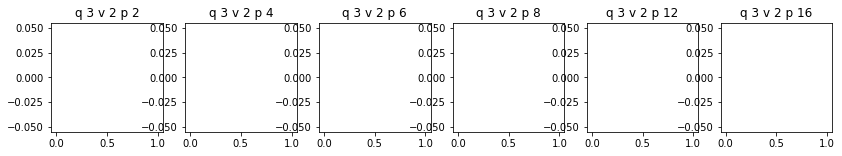

In [79]:
%matplotlib inline
qid = 3
vid = 2

fig, axs = plt.subplots(1, 6, figsize=(14,2))
ctr = 0
for paralle in [2,4,6,8,12,16]:
    
    df2_naive = df2[df2['query_idx']==qid]
    df2_naive = df2_naive[df2_naive['vertex_idx']==vid]
    df2_naive = df2_naive[df2_naive['parallelism']==paralle]

    axs[ctr].hist(df2_naive['busyTimeMsPerSecond'], bins=50,)
    axs[ctr].set_title(" ".join(['q',str(qid),'v',str(vid),'p',str(paralle)]))
    ctr+=1
plt.show()

### calculate selectivity for each non-last vertex

In [33]:
# 1. make sure for each vertex we can find its true selectivity information:
df_naive_nonBP_all = df_naive[(df_naive['isBackPressured'] == 'false')]
allVhasNonBP = ('q' + df_naive_nonBP_all['query_idx'].astype(str) + 'v' + df_naive_nonBP_all['vertex_idx'].astype(str)).unique()
allVhasNonBP, len(allVhasNonBP)

(array(['q4v0', 'q4v1', 'q4v2', 'q4v3', 'q5v0', 'q5v1', 'q5v2', 'q5v3',
        'q7v0', 'q7v1', 'q7v2', 'q9v0', 'q9v1', 'q9v2', 'q3v0', 'q3v1',
        'q8v0', 'q8v1', 'q8v2', 'q8v3', 'q10v0', 'q10v1', 'q11v0', 'q11v1',
        'q12v0', 'q12v1', 'q15v0', 'q15v1', 'q16v0', 'q16v1', 'q17v0',
        'q17v1', 'q18v0', 'q18v1', 'q19v0', 'q19v1', 'q20v0', 'q20v1'],
       dtype=object),
 38)

In [34]:
# 2. firstly compute for all 0-idx vertices with given tps
df_naive_nonBP['true_selectivity_records'] = df_naive_nonBP['numRecordsOutPerSecond'] / df_naive_nonBP['perSbTps']
df_naive_nonBP['true_selectivity_bytes'] = df_naive_nonBP['numBytesOutPerSecond'] / df_naive_nonBP['perSbTps']
df_naive_nonBP

/tmp/ipykernel_59551/2477790254.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_naive_nonBP['true_selectivity_records'] = df_naive_nonBP['numRecordsOutPerSecond'] / df_naive_nonBP['perSbTps']
/tmp/ipykernel_59551/2477790254.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_naive_nonBP['true_selectivity_bytes'] = df_naive_nonBP['numBytesOutPerSecond'] / df_naive_nonBP['perSbTps']


,query_idx,parallel,tps,vertex_idx,parallelism,sub_idx,busyTimeMsPerSecond,numBytesOutPerSecond,numRecordsOutPerSecond,numBytesInPerSecond,numRecordsInPerSecond,isBackPressured,in_stream_num,out_stream_num,perSbTps,true_selectivity_records,true_selectivity_bytes
0,4,2,10000.0,0,2,0,NaN,3.440640e+04,838.700000,0.0,0.0,false,0,1,5000.0,0.167740,6.881280
1,4,2,10000.0,0,2,1,NaN,3.386027e+04,838.700000,0.0,0.0,false,0,1,5000.0,0.167740,6.772053
8,4,2,10000.0,0,2,0,NaN,6.772053e+04,1655.450000,0.0,0.0,false,0,1,5000.0,0.331090,13.544107
9,4,2,10000.0,0,2,1,NaN,6.772053e+04,1655.433333,0.0,0.0,false,0,1,5000.0,0.331087,13.544107
16,4,2,10000.0,0,2,0,NaN,1.014551e+05,2472.283333,0.0,0.0,false,0,1,5000.0,0.494457,20.291020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107921,20,16,2400000.0,0,16,1,NaN,9.022123e+05,4062.616667,0.0,0.0,false,0,1,150000.0,0.027084,6.014748
107926,20,16,2400000.0,0,16,6,NaN,8.028160e+05,3620.516667,0.0,0.0,false,0,1,150000.0,0.024137,5.352107
108022,20,16,2400000.0,0,16,6,NaN,2.701722e+06,12100.333333,0.0,0.0,false,0,1,150000.0,0.080669,18.011477
108026,20,16,2400000.0,0,16,10,NaN,2.411179e+06,10816.150000,0.0,0.0,false,0,1,150000.0,0.072108,16.074524


In [38]:
qid = 15
true_selectivities_0s_mean = []
true_selectivities_0s_max = []
for qid in [3,10,11,12,15,16,17,18,19,20,7,9,4,5,8,]:
    ##
    avg_true_selectivity_records_mean = np.mean(df_naive_nonBP[(df_naive_nonBP['query_idx']==qid) & (df_naive_nonBP['vertex_idx']==0)]['true_selectivity_records'])
    avg_true_selectivity_bytes_mean = np.mean(df_naive_nonBP[(df_naive_nonBP['query_idx']==qid) & (df_naive_nonBP['vertex_idx']==0)]['true_selectivity_bytes'])
    true_selectivities_0s_mean.append([qid, 0, avg_true_selectivity_records_mean, avg_true_selectivity_bytes_mean])
    ##
    avg_true_selectivity_records_max = np.max(df_naive_nonBP[(df_naive_nonBP['query_idx']==qid) & (df_naive_nonBP['vertex_idx']==0)]['true_selectivity_records'])
    avg_true_selectivity_bytes_max = np.max(df_naive_nonBP[(df_naive_nonBP['query_idx']==qid) & (df_naive_nonBP['vertex_idx']==0)]['true_selectivity_bytes'])
    true_selectivities_0s_max.append([qid, 0, avg_true_selectivity_records_max, avg_true_selectivity_bytes_max])

In [46]:
print(
true_selectivities_0s_mean, # outRecords/inputRecords, and outBytes/inputRecords
'\n',true_selectivities_0s_max)

# make compatible
true_selectivities_0s = true_selectivities_0s_max
true_selectivities_0s

[[3, 0, 0.01617300468409586, 0.6810972130718954], [10, 0, 2.534979423868313e-07, 0.0010509843621399175], [11, 0, 0.6726323098843693, 22.094161085754536], [12, 0, 0.6713340591853196, 22.079498634422265], [15, 0, 0.6932316232959345, 56.158943730848115], [16, 0, 0.6731368146825398, 71.2333128161977], [17, 0, 0.6564263170751338, 53.09597818988692], [18, 0, 0.6703125484013426, 147.11353561752927], [19, 0, 0.6271182971569771, 137.64395987670054], [20, 0, 0.6591435695819582, 147.2903163747839], [7, 0, 1.2670766402032947, 101.72114405502981], [9, 0, 0.6792085830197133, 162.8975794798387], [4, 0, 0.7134230608788854, 29.3562483091104], [5, 0, 0.6746866944805664, 22.14287440593845], [8, 0, 0.05863777322076979, 2.1607193068264343]] 
 [[3, 0, 0.023453333333333333, 1.5177141666666667], [10, 0, 3.3333333333333333e-06, 0.024669999999999997], [11, 0, 0.9696389999999999, 32.03618133333333], [12, 0, 0.9992896666666666, 33.01376], [15, 0, 0.9611816666666667, 77.86029], [16, 0, 0.9213808333333332, 98.08554

[[3, 0, 0.023453333333333333, 1.5177141666666667],
 [10, 0, 3.3333333333333333e-06, 0.024669999999999997],
 [11, 0, 0.9696389999999999, 32.03618133333333],
 [12, 0, 0.9992896666666666, 33.01376],
 [15, 0, 0.9611816666666667, 77.86029],
 [16, 0, 0.9213808333333332, 98.08554666666667],
 [17, 0, 0.9784725555555556, 79.25486933333333],
 [18, 0, 0.9236633333333333, 203.27082666666666],
 [19, 0, 1.0976391666666667, 241.2270933333333],
 [20, 0, 1.0542883333333333, 236.06613333333334],
 [7, 0, 2.077105, 167.1168],
 [9, 0, 1.00889, 242.9201066666667],
 [4, 0, 0.9891866666666667, 42.16149333333333],
 [5, 0, 0.9206566666666668, 31.020373333333335],
 [8, 0, 0.08321333333333333, 4.150613333333333]]

In [44]:
# 3. calculate for other non-first vertices with mean out-in recerds rate
df_naive_nonBP_all_non0 = df_naive_nonBP_all[df_naive_nonBP_all['vertex_idx'] != 0]
df_naive_nonBP_all_non0['true_selectivity_bytes'] = df_naive_nonBP_all_non0['numBytesOutPerSecond'] / df_naive_nonBP_all_non0['numBytesInPerSecond']
df_naive_nonBP_all_non0['true_selectivity_records'] = df_naive_nonBP_all_non0['numRecordsOutPerSecond'] / df_naive_nonBP_all_non0['numRecordsInPerSecond']
# df.groupby(['group_col1', 'group_col2'])['value_col'].mean()
true_selectivities_non0s = df_naive_nonBP_all_non0.groupby(['query_idx', 'vertex_idx'])['true_selectivity_records', 'true_selectivity_bytes'].mean()

/tmp/ipykernel_59551/1213949400.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_naive_nonBP_all_non0['true_selectivity_bytes'] = df_naive_nonBP_all_non0['numBytesOutPerSecond'] / df_naive_nonBP_all_non0['numBytesInPerSecond']
/tmp/ipykernel_59551/1213949400.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_naive_nonBP_all_non0['true_selectivity_records'] = df_naive_nonBP_all_non0['numRecordsOutPerSecond'] / df_naive_nonBP_all_non0['numRecordsInPerSecond']
/tmp/ipykernel_59551/1213949400.py:6: Fu

In [45]:
true_selectivities_non0s.to_dict()

{'true_selectivity_records': {(3, 1): 0.0,
  (4, 1): 0.6912518503136653,
  (4, 2): 0.304985801322673,
  (4, 3): 0.0,
  (5, 1): 0.41727981517418583,
  (5, 2): 0.0002818181698208077,
  (5, 3): 0.0,
  (7, 1): 1.4371688367287177e-06,
  (7, 2): 0.0,
  (8, 1): 0.7527639835282477,
  (8, 2): 0.13995420932258743,
  (8, 3): 0.0,
  (9, 1): 0.691004748134965,
  (9, 2): 0.0,
  (10, 1): 0.0,
  (11, 1): 0.0,
  (12, 1): 0.0,
  (15, 1): 0.0,
  (16, 1): 0.0,
  (17, 1): 0.0,
  (18, 1): 0.0,
  (19, 1): 0.0,
  (20, 1): 0.0},
 'true_selectivity_bytes': {(3, 1): 0.0,
  (4, 1): 0.6753447790534581,
  (4, 2): 0.24189611914570386,
  (4, 3): 0.0,
  (5, 1): 0.5615594931593035,
  (5, 2): 0.05540181310893822,
  (5, 3): 0.0,
  (7, 1): 8.078045795509287e-05,
  (7, 2): 0.0,
  (8, 1): 0.7724989981804393,
  (8, 2): 0.14459429349535374,
  (8, 3): 0.0,
  (9, 1): 1.9174096940261507,
  (9, 2): 0.0,
  (10, 1): 0.0,
  (11, 1): 0.0,
  (12, 1): 0.0,
  (15, 1): 0.0,
  (16, 1): 0.0,
  (17, 1): 0.0,
  (18, 1): 0.0,
  (19, 1): 0.0,


In [2]:
45 * 4

180